### Login details

In [1]:
#Name     : Rudraksh Goel
#Type     : Standard AUD Demo Account
#Server   : GoMarkets-Demo
#Login    : 62986
#Password : xo7rslrx
#Investor : we5sweua

## Import modules

In [57]:
import time
startTime = time.time()

# from datetime import datetime
import datetime
import MetaTrader5 as mt5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import mplfinance as mpf
import csv
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore") # Ignore warnings for sklearn etc

#Uncomment to turn off the warnings for pandas:
pd.options.mode.chained_assignment = None  # default='warn'

from IPython.display import display, HTML

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 200
pd.options.display.float_format = "{:,.5f}".format

display(HTML("<style>.container { width:80% !important; }</style>"))
print('Importing and set up time = %0.4f' % (time.time() - startTime))

Importing and set up time = 0.0020


In [58]:
%autosave 30

Autosaving every 30 seconds


### Initialise the connection to metatrader 5

In [59]:
initTime = time.time()

if not mt5.initialize():
    print(mt5.last_error())
    mt5.shutdown()
else:
    authorized=mt5.login(62986, password="xo7rslrx")
    account_info=mt5.account_info()
    print(account_info)
    print('\nInitialised mt5 successfully! Took %0.3f seconds...\n' % (time.time() - initTime))

AccountInfo(login=62986, trade_mode=0, leverage=100, limit_orders=0, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=1000.0, credit=0.0, profit=0.0, equity=1000.0, margin=0.0, margin_free=1000.0, margin_level=0.0, margin_so_call=80.0, margin_so_so=50.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Rudraksh Goel', server='GoMarkets-Demo', currency='AUD', ...)

Initialised mt5 successfully! Took 0.010 seconds...



# Set time period

In [60]:
timePeriod = mt5.TIMEFRAME_M15

### Try to get data for a period of time and show RSI + Bollinger bands

In [61]:
from datetime import datetime as dt
signal = 'AUDUSD'

## Datetime in format - (year, month, day, time (24hr))
numDays = 10
today = dt.now()
daysBef = datetime.timedelta(days = numDays)
startDate = today - daysBef
print(startDate, today)

startDate = dt.combine(startDate, dt.min.time())
# today = dt.combine(today, dt.min.time())

audusd_rates = mt5.copy_rates_range(signal, timePeriod, startDate, today)

audusd = pd.DataFrame(audusd_rates)
audusd['time']=pd.to_datetime(audusd['time'], unit='s')
audusd.head()

2020-09-23 12:34:30.189075 2020-10-03 12:34:30.189075


,time,open,high,low,close,tick_volume,spread,real_volume
0,2020-09-22 14:00:00,0.72281,0.72281,0.72222,0.72229,898,0,535120000
1,2020-09-22 14:15:00,0.72232,0.72262,0.72209,0.72228,598,0,288068000
2,2020-09-22 14:30:00,0.72227,0.72252,0.72197,0.72209,808,1,658674000
3,2020-09-22 14:45:00,0.72208,0.72209,0.72137,0.72155,1022,0,829079000
4,2020-09-22 15:00:00,0.72156,0.72170,0.72056,0.72076,1102,1,663776000


In [62]:
oldest = min(audusd['time'])
newest = max(audusd['time'])
oldest, newest

(Timestamp('2020-09-22 14:00:00'), Timestamp('2020-10-02 23:45:00'))

In [63]:
# First just try to plot the signal itself
plot_df = audusd.drop(columns=['time', 'tick_volume', 'spread', 'real_volume'])
plot_df['Date'] = pd.to_datetime(audusd['time'])
plot_df = plot_df.set_index('Date')
# display(plot_df.head())

# Plot the results
# mpf.plot(plot_df, type='candle', figsize=(10,6), style='charles')

### Calculate the bollinger bands

In [64]:
# Default values for bollinger bands = 20 for period & 2 for std
period = 20
closePrices = plot_df['close'].values
bands = {k:[] for k in ['topBand','bottomBand', 'mav']} # Set lists as defaults

for i in range(1, len(closePrices)+1):
    if i < period:
        currDat = closePrices[0:i]
    else:
        currDat = closePrices[i-period:i]
        
    std = np.std(currDat)
    mean = np.mean(currDat)

    bands['topBand'].append(mean+2*std)
    bands['bottomBand'].append(mean-2*std)
    bands['mav'].append(mean)
    
# Remove the first n (period) of values as they are not accurate/just used for calculation
for key, val in bands.items():
    tempVal = val.copy()
    tempVal[:period] = [float('nan')]*period
    bands[key] = tempVal

### Calculate/get the RSI indicator

In [103]:
import numba as nb
close = plot_df['close']

@nb.jit(fastmath=True, nopython=True)   
def calc_rsi( array, deltas, avg_gain, avg_loss, n ):

    # Use Wilder smoothing method
    up   = lambda x:  x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_gain = ((avg_gain * (n-1)) + up(d)) / n
        avg_loss = ((avg_loss * (n-1)) + down(d)) / n
        if avg_loss != 0:
            rs = avg_gain / avg_loss
            array[i] = 100 - (100 / (1 + rs))
        else:
            array[i] = 100
        i += 1

    return array

def get_rsi( array, n = 14 ):   

    deltas = np.append([0],np.diff(array))

    avg_gain =  np.sum(deltas[1:n+1].clip(min=0)) / n
    avg_loss = -np.sum(deltas[1:n+1].clip(max=0)) / n

    array = np.empty(deltas.shape[0])
    array.fill(np.nan)

    array = calc_rsi( array, deltas, avg_gain, avg_loss, n )
    return array

rsi = get_rsi(close, 14)
# print(rsi)

### Plot the RSI indicator below the boll bands

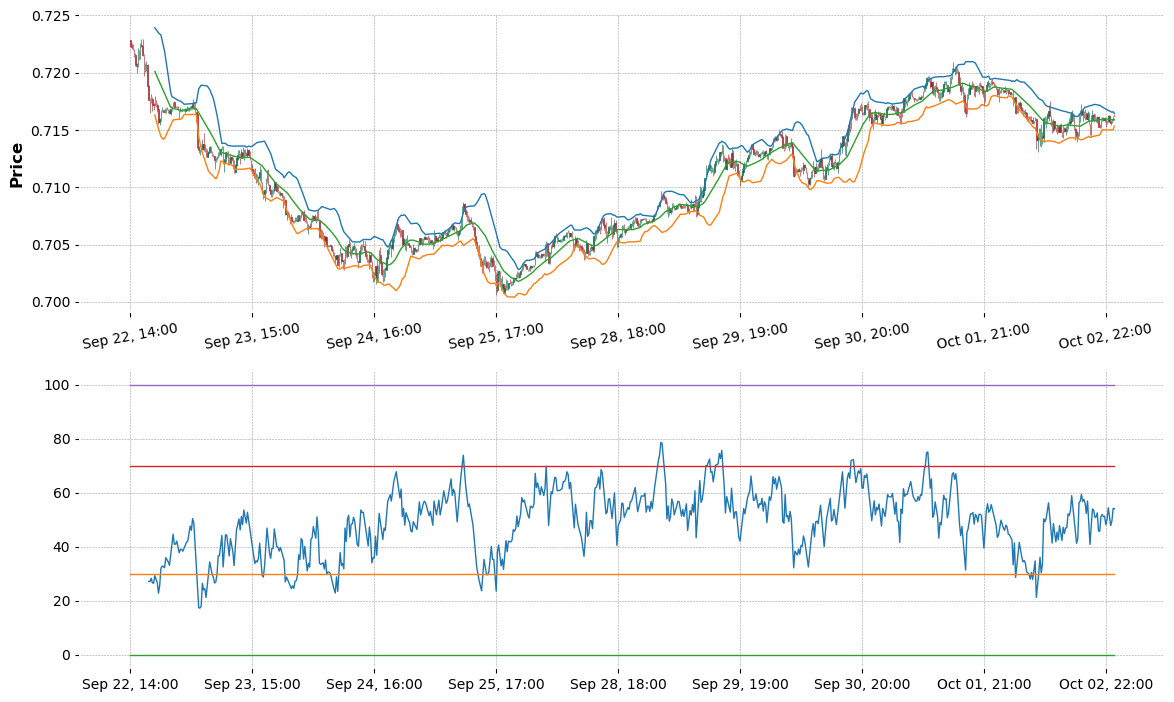

In [66]:
## Create a figure for the mpf
s  = mpf.make_mpf_style(base_mpf_style='charles', y_on_right=False)
fig = mpf.figure(style=s, figsize = (14, 6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
fig.subplots_adjust(top=1.2)

# Make the Bollinger band subplot
bollDf = pd.DataFrame.from_dict(bands)
addBoll = mpf.make_addplot(bollDf, width=1, ax=ax1)

# Thresholds for the RSI being a snapback
threshUp = 70
threshDown = 30  

# Make the RSI subplot
RSIvals = [rsi, [threshDown]*len(rsi), [0]*len(rsi), [threshUp]*len(rsi), [100]*len(rsi)]
rsiDf = pd.DataFrame(RSIvals).T
rsiDf['Date'] = pd.to_datetime(audusd['time'])
rsiDf = rsiDf.set_index('Date')
addRsi = mpf.make_addplot(rsiDf, width=1, ax=ax2)

# Plot stuff
mpf.plot(plot_df, ax=ax1, addplot=[addBoll, addRsi], type='candle', xrotation=10)

# Implement the algorithm to check if there is a good trade to make

In [82]:
# At the most recent datetime, is the signal both above/below the threshold for the RSI and touching a bollinger band:

# First get the RSI, signal and Bollinger bands in a dataframe with respect to time
algDf = pd.DataFrame()
algDf['Date'] = pd.to_datetime(audusd['time'])
algDf = algDf.set_index('Date')

# Add the RSI values
algDf['RSI'] = list(rsi)

# Add the signal values (using the close value)
algDf['Signal'] = plot_df['close']

# Add the bollinger bands (can use the mav to figure out the take-profit value)
bollDf.reset_index(inplace=True)
bollDf['Date'] = pd.to_datetime(audusd['time'])
bollDf = bollDf.set_index('Date')

algDf = pd.concat([algDf, bollDf], axis=1)
display(algDf.head())

,RSI,Signal,topBand,bottomBand,mav
Date,,,,,
2020-09-22 14:00:00,nan,0.72229,nan,nan,nan
2020-09-22 14:15:00,nan,0.72228,nan,nan,nan
2020-09-22 14:30:00,nan,0.72209,nan,nan,nan
2020-09-22 14:45:00,nan,0.72155,nan,nan,nan
2020-09-22 15:00:00,nan,0.72076,nan,nan,nan


In [96]:
# Just get the array where the most recent time stamp is
recentTime = max(algDf.index)
recentDf = algDf[algDf.index==recentTime]
recentDf

,RSI,Signal,topBand,bottomBand,mav
Date,,,,,
2020-10-02 23:45:00,54.04412,0.71618,0.71645,0.71533,0.71589


### Implement the checks


In [102]:
# Thresholds for the RSI being a snapback
threshUp = 70
threshDown = 30  

recDict = recentDf.to_dict(orient='list')

makeTrade = False
# Case 1 - signal is above topBand and RSI is > upperthresh
if (recDict['Signal'] > recDict['topBand']) and (recDict['RSI'] > threshUp):
    makeTrade = True
elif (recDict['Signal'] < recDict['bottomBand'] and (recDict['RSI'] < threshDown)):
    makeTrade = True
else:
    pass

{'RSI': [54.04411702145899], 'Signal': [0.71618], 'topBand': [0.7164457311180128], 'bottomBand': [0.7153302688819869], 'mav': [0.7158879999999999]}
